In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import anndata


plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

In [6]:
AML_S2_patients = np.array(["P"+str(i) for i in np.arange(1, 5)])
AML_10X_patients = np.array(["A"+str(i) for i in np.arange(1, 16)])
LUNG_patients = ["p018", "p019", "p023", "p030", "p031","p032", "p033"]
CRC_patients = ["p007", "p013", "p014", "p016", "p020", "p026"]

all_patients = np.concatenate([AML_S2_patients, AML_10X_patients, LUNG_patients, CRC_patients])

# Total number of observed variants is correlated to the cell size

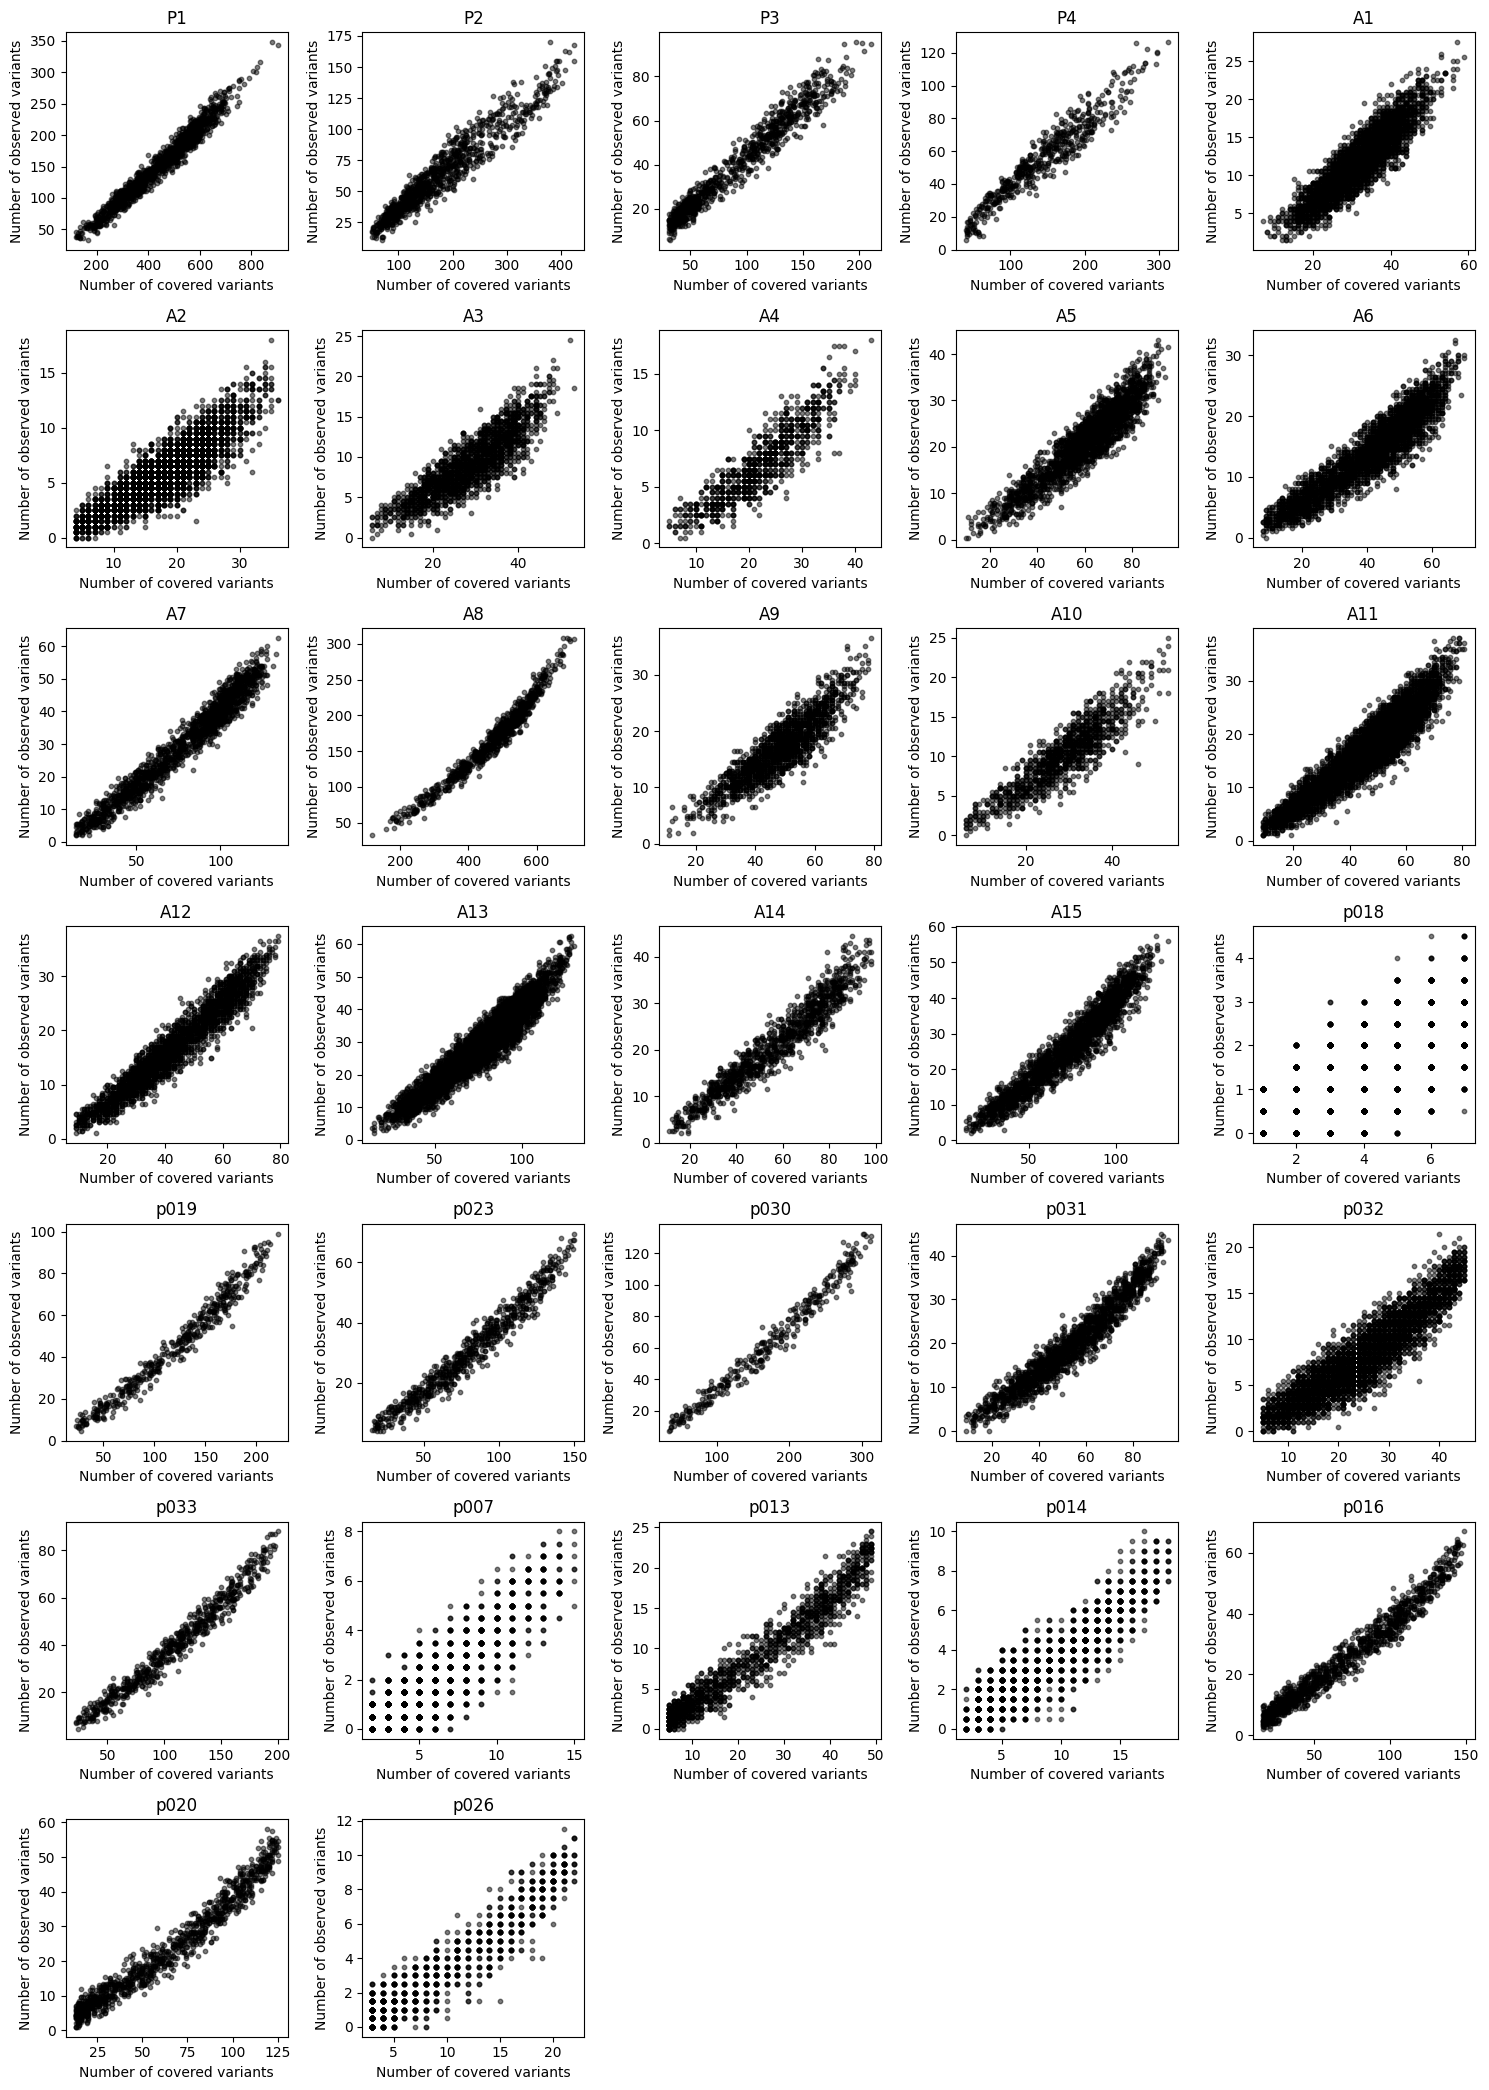

In [7]:
fig, axs = plt.subplots(7, 5, figsize=(15, 21))
for i, patient in enumerate(all_patients):
    
        adata = anndata.read_h5ad("/home/vmarotl/fast/mutaseq/runs/k2_"+patient+"_True_5.h5ad")

        M = np.sum(adata.layers["M"], axis=1)
        cov = np.sum(adata.X>=2, axis=1)
        ax = axs[ int(np.floor(i/5)), i%5]

        ax.scatter(cov, M, 
                   c="black", alpha=.5, s=10)
        ax.set_title(patient)
        ax.set_xlabel("Number of covered variants")
        ax.set_ylabel("Number of observed variants")

for i in range(3):
    ax = axs[6, i+2]
    ax.axis('off')
    
plt.tight_layout()
plt.savefig("../figures/S1_variants_cellsize.png", dpi=300)
plt.show()

# Can the number of variants be used to determine whether a cell is cancer or not?

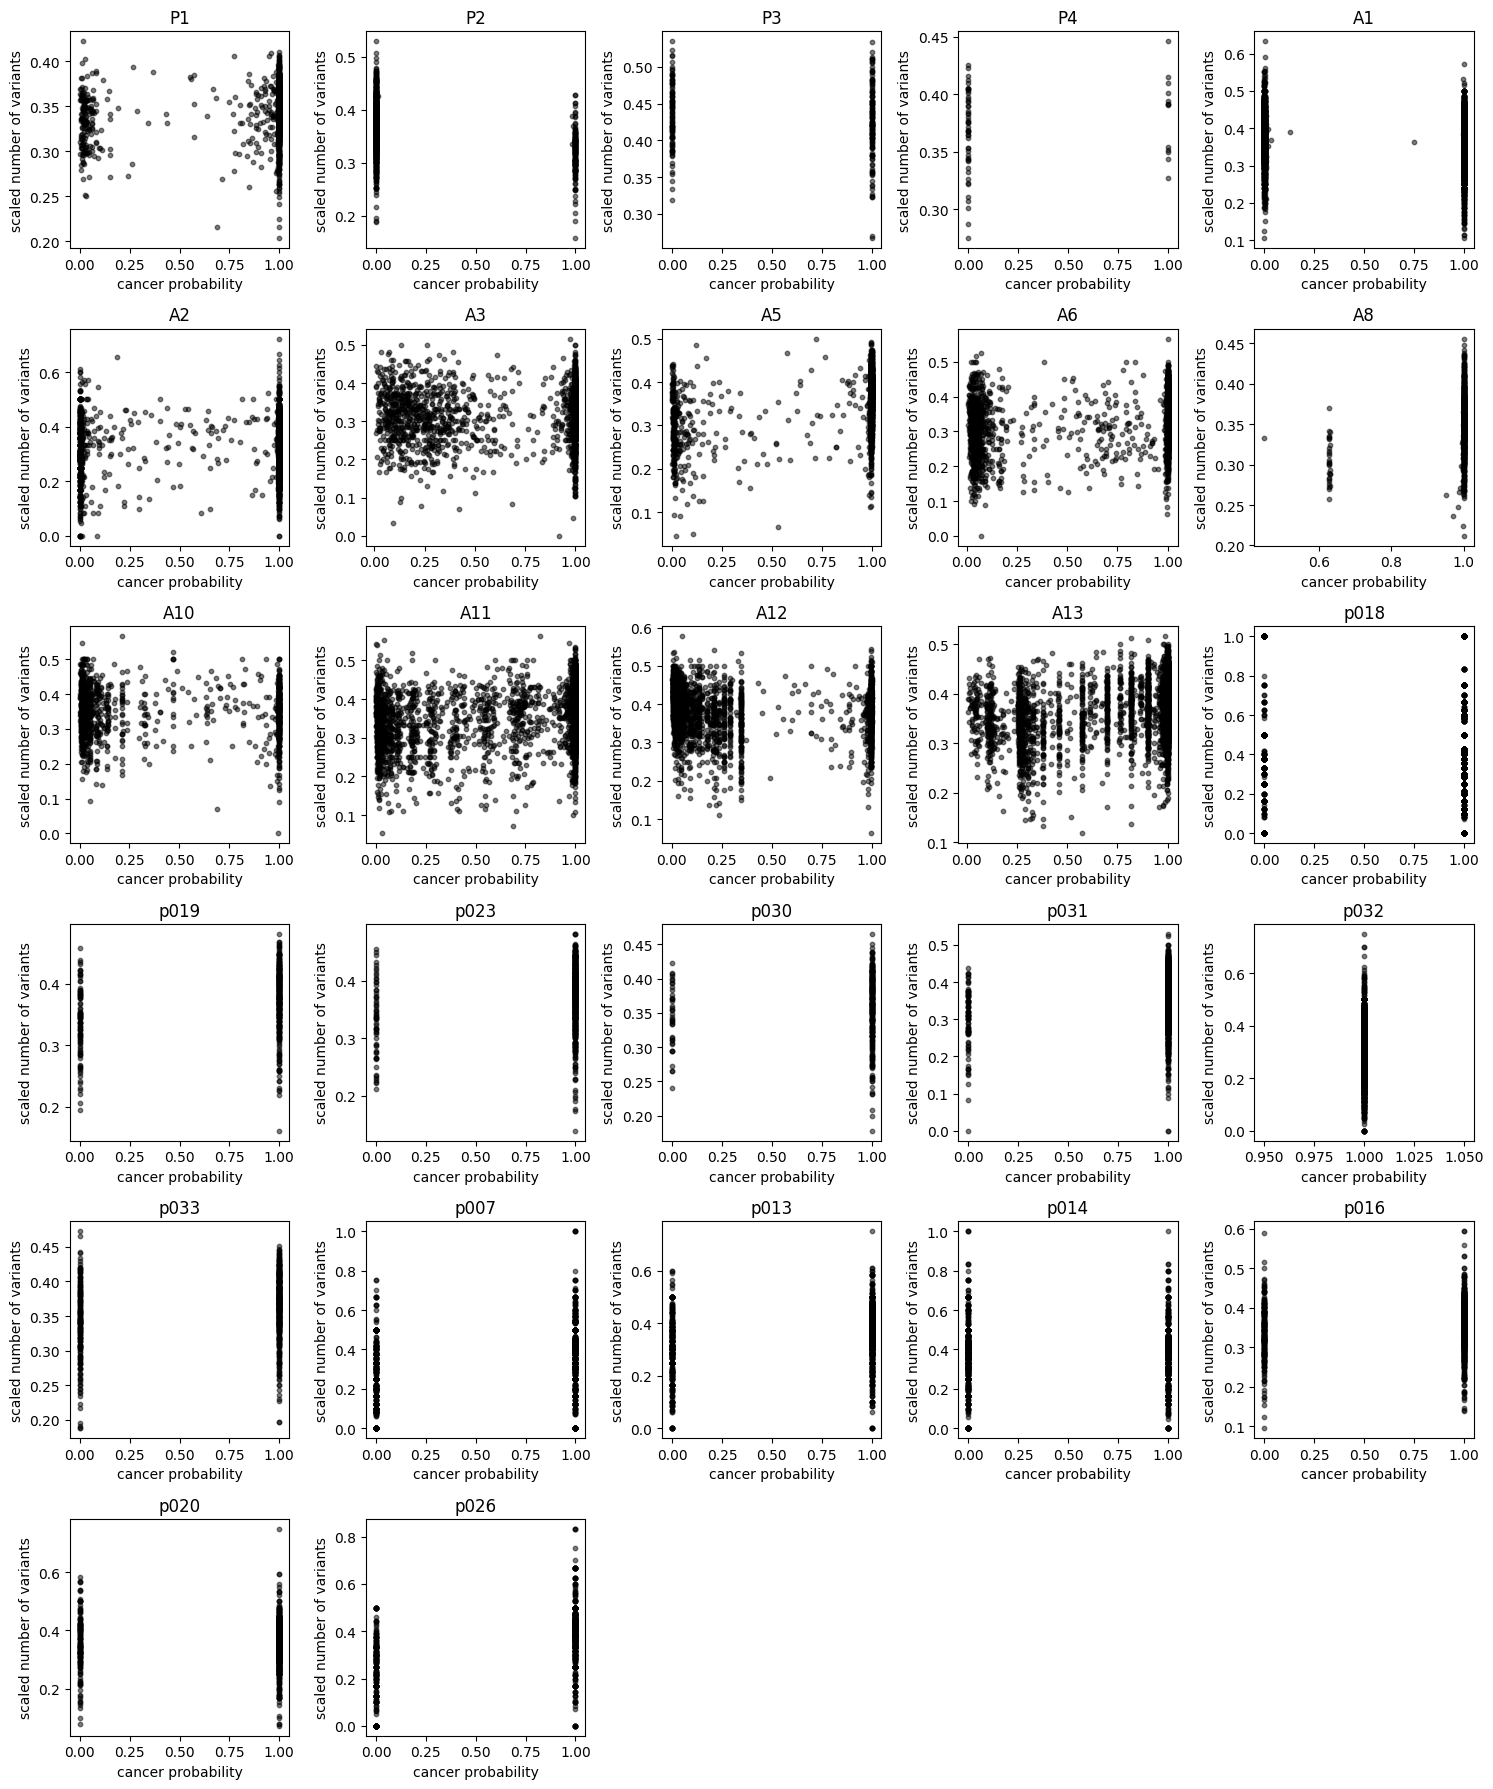

In [8]:

fig, axs = plt.subplots(6, 5, figsize=(15, 18))

i = 0
for patient in all_patients:
    adata = anndata.read_h5ad("/home/vmarotl/fast/mutaseq/runs/k2_"+patient+"_True_5.h5ad")
    
    path = "../ref_data/" 
    path += "AML_MutaSeq/" if patient in AML_S2_patients else "AML_10X/" if patient in AML_10X_patients else "LUNG/" if patient in LUNG_patients else "CRC/"
    try:
        ref = pd.read_csv(path+patient+"/ref.csv", index_col=0)
        cells = np.intersect1d(adata.obs_names, ref.index)
        ref = ref.loc[cells]
        ref = (ref["cancer_final"] if i in [2, 3] else 1-ref["PhiSICShealthy"]) if patient in AML_S2_patients else 1-ref["Healthy"] if patient in AML_10X_patients else ref["cna_clone"] == "CNA" if patient in LUNG_patients else ref["consensus_call"]=="genomically_tumour"
        adata = adata[cells]
    except:
        continue

    M = np.sum(adata.layers["M"], axis=1)
    cov = np.sum(adata.X>=2, axis=1)
    ax = axs[ int(np.floor(i/5)), i%5]

    ax.scatter(1-ref if i in [1, 2] else ref, M/cov, 
               c="black", alpha=.5, s=10)
    ax.set_title(patient)
    ax.set_xlabel("cancer probability")
    ax.set_ylabel("scaled number of variants")
    i+=1

for i in range(3):
    ax = axs[5, i+2]
    ax.axis('off')
    
plt.tight_layout()
plt.savefig("../figures/S2_variants_scaled.png", dpi=300)
plt.show()

# Imbalance in allelic expression

In [29]:
cm = plt.cm.get_cmap('YlGnBu_r')

vmax_cov = 11
color = [cm(i/(vmax_cov-1)) for i in range(vmax_cov)]

cm = plt.cm.get_cmap('Greys')

vmax_cov = 11
grey_color = [cm(i/(vmax_cov-1)) for i in range(vmax_cov)]

hist_kwargs = {"color":color, "stacked":True, "bins":11, "range":(0, 1)}
hist_grey_kwargs = {"color":grey_color, "stacked":True, "bins":11, "range":(0, 1)}

/tmp/7181828.1.all.q/ipykernel_6643/404358401.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('YlGnBu_r')
/tmp/7181828.1.all.q/ipykernel_6643/404358401.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Greys')


/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(


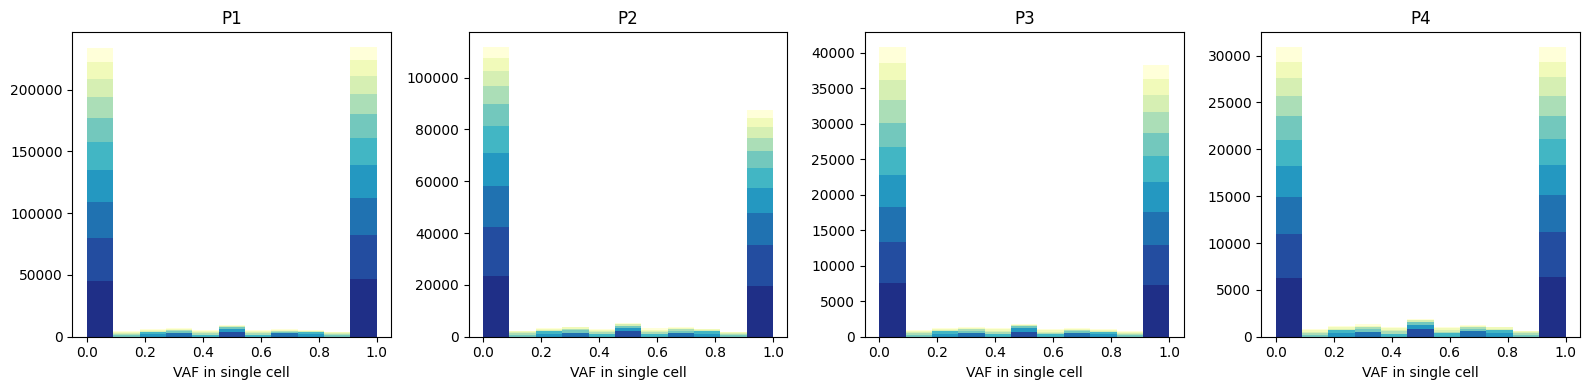

In [43]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in np.arange(1, 5):
    patient = "P"+str(i)
    
    ax = axs[(i-1)%4]
    
    adata = anndata.read_h5ad("/home/vmarotl/fast/mutaseq/runs/k2_"+patient+"_False_5.h5ad")
    adata = adata[:,adata.var["dbSNP"]==True]

    data, cov = (adata.layers["ALT"]/adata.X).flatten(), (adata.X).flatten()
    x = [data[((cov>=i) & (cov<i+1)) if i<=(vmax_cov-1) else cov >= i] for i in range(vmax_cov)]
    
    ax.hist(x, **hist_kwargs)
    ax.set_title(patient)
    ax.set_xlabel("VAF in single cell")
    
plt.tight_layout()
plt.savefig("../figures/S3_extra_SmartSeq2-VAF-in-sc.png", dpi=300)

/tmp/7181828.1.all.q/ipykernel_6643/4014874815.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('YlGnBu_r')
/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in

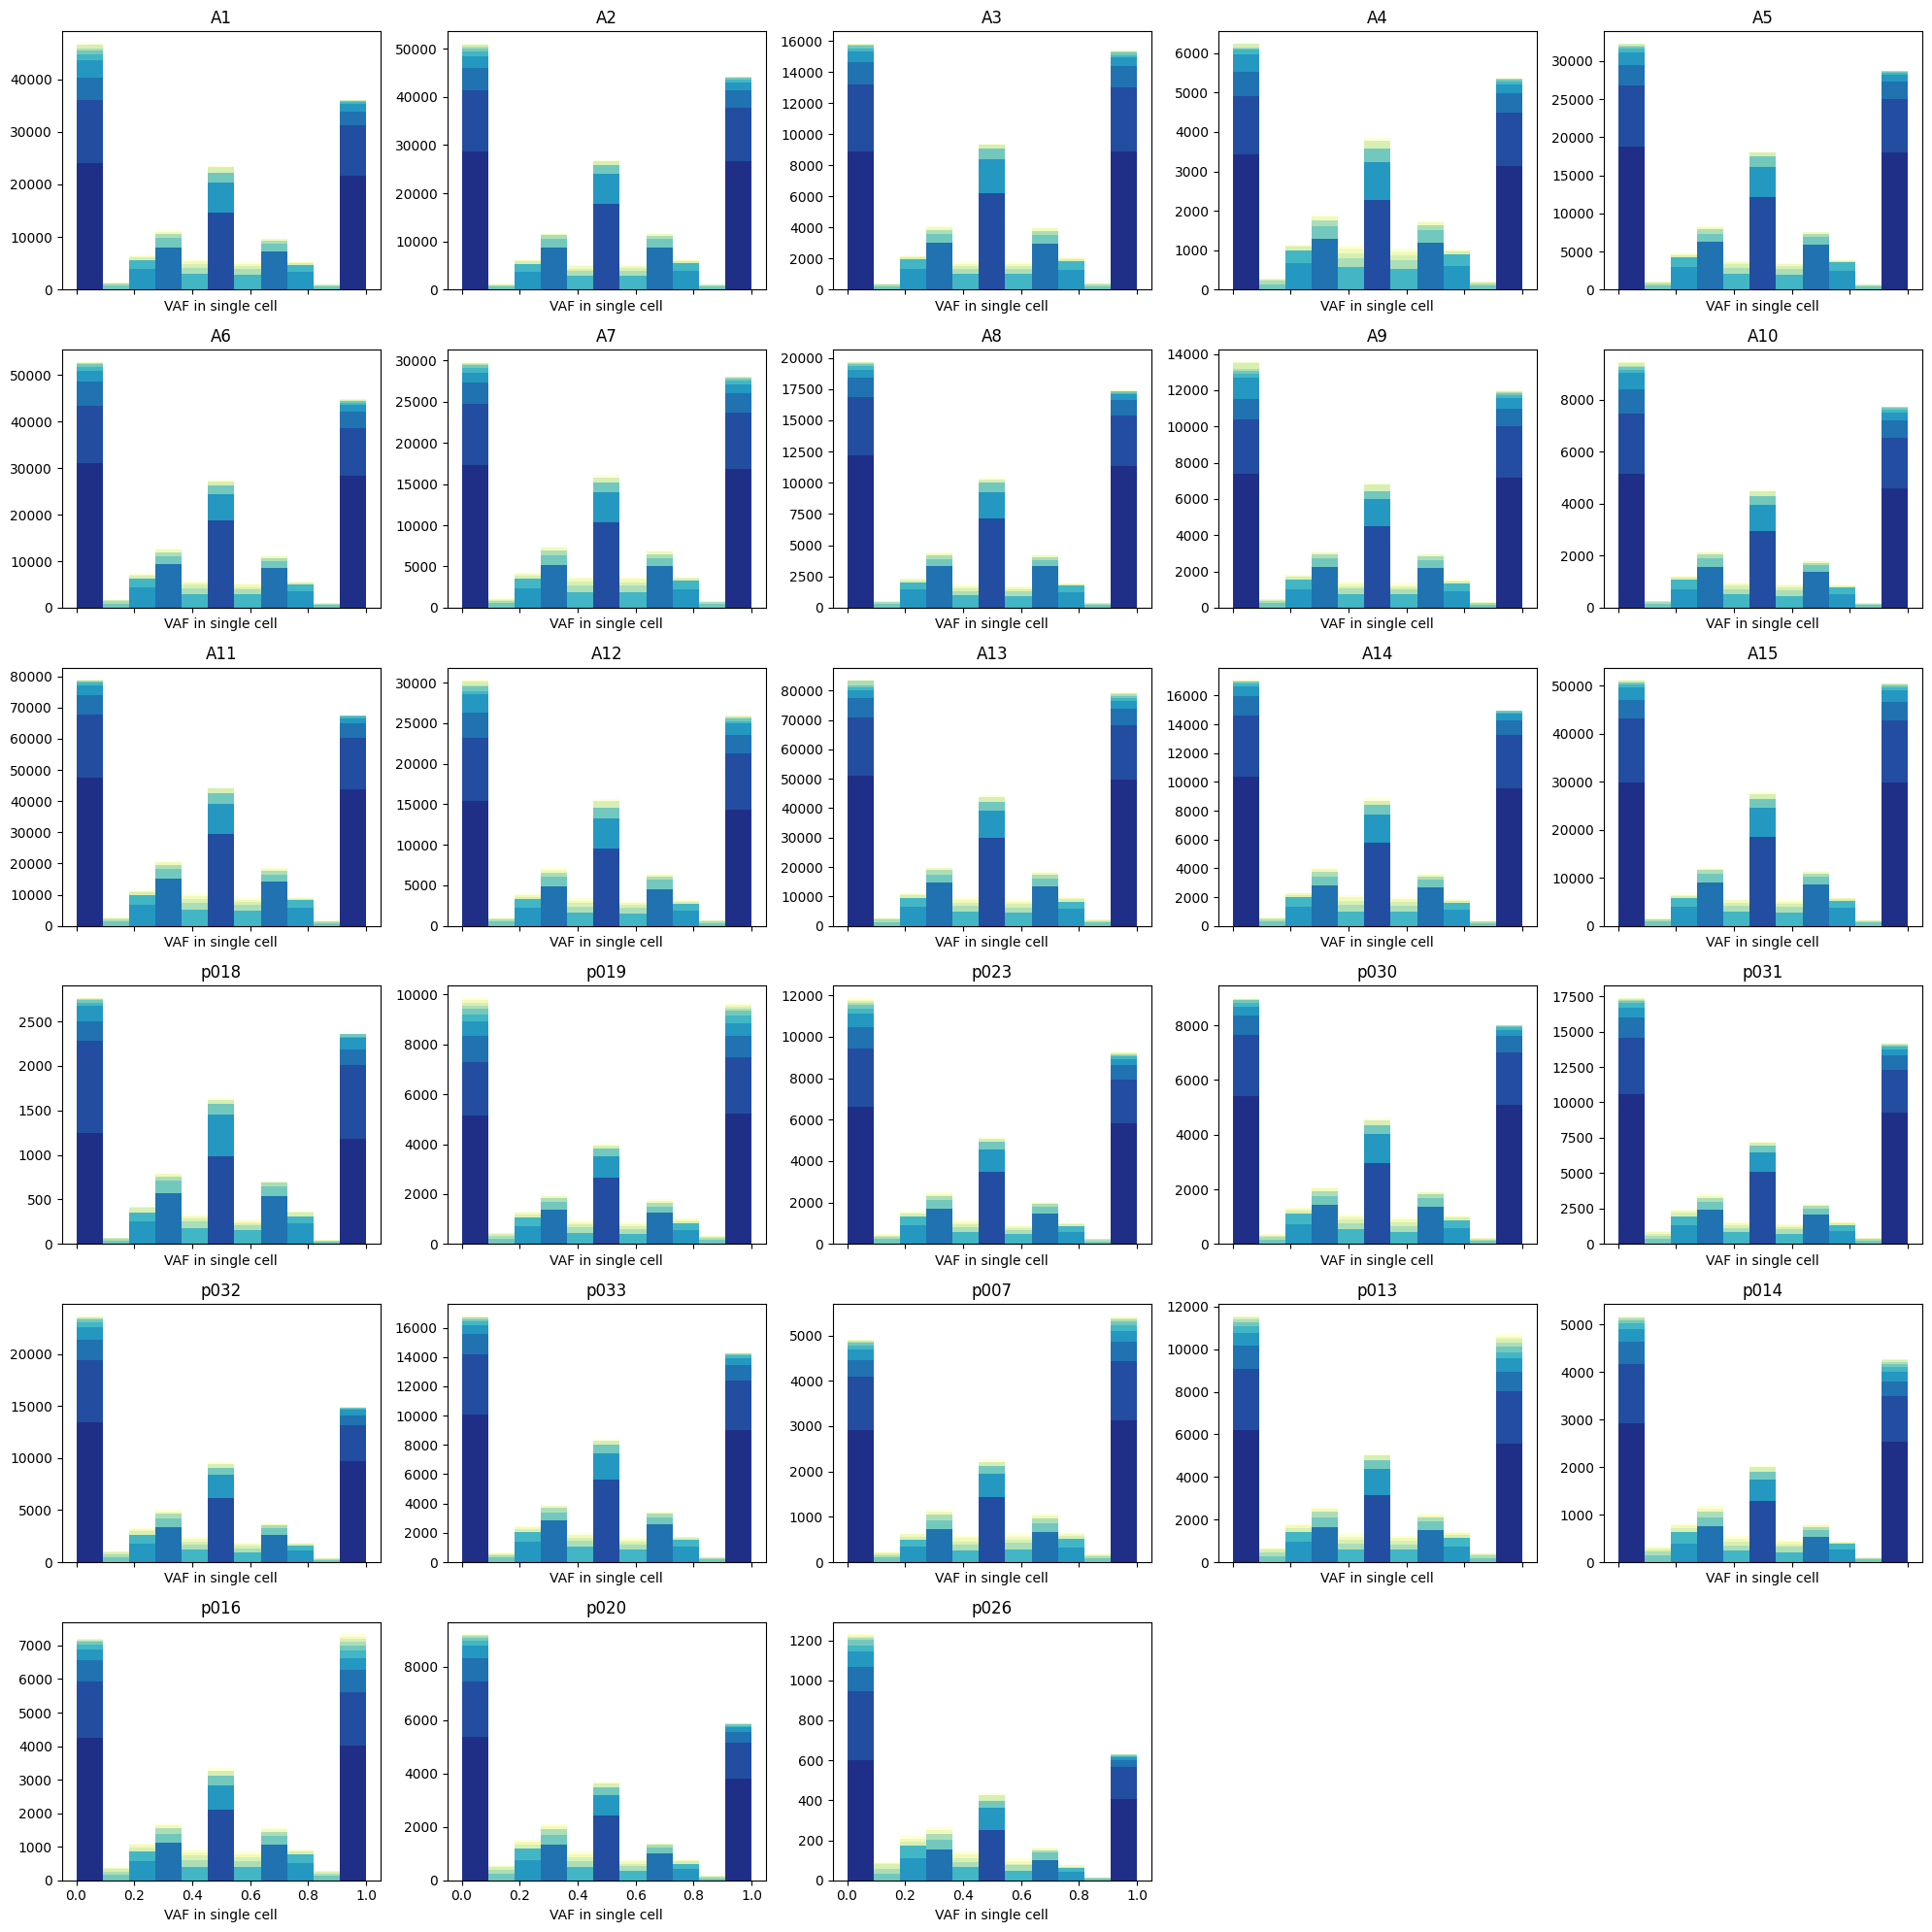

In [44]:
cm = plt.cm.get_cmap('YlGnBu_r')

fig, axs = plt.subplots(6, 5, figsize=(20, 20), sharex=True)
all_patients = np.concatenate([AML_10X_patients, LUNG_patients, CRC_patients])

for i, patient in enumerate(all_patients):
    
    ax = axs[ int(np.floor(i/5)), i%5]
    
    adata = anndata.read_h5ad("/home/vmarotl/fast/mutaseq/runs/k2_"+patient+"_False_5.h5ad")
    adata = adata[:,adata.var["dbSNP"]==True]

    data, cov = (adata.layers["ALT"]/adata.X).flatten(), (adata.X).flatten()
    x = [data[((cov>=i) & (cov<i+1)) if i<=(vmax_cov-1) else cov >= i] for i in range(vmax_cov)]  
    
    ax.hist(x, **hist_kwargs)
    ax.set_title(patient)
    ax.set_xlabel("VAF in single cell")
    
for i in range(2):
    ax = axs[5, i+3]
    ax.axis('off')
    
plt.tight_layout()
plt.savefig("../figures/S3_extra_10X-VAF-in-sc.png", dpi=300)

/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(


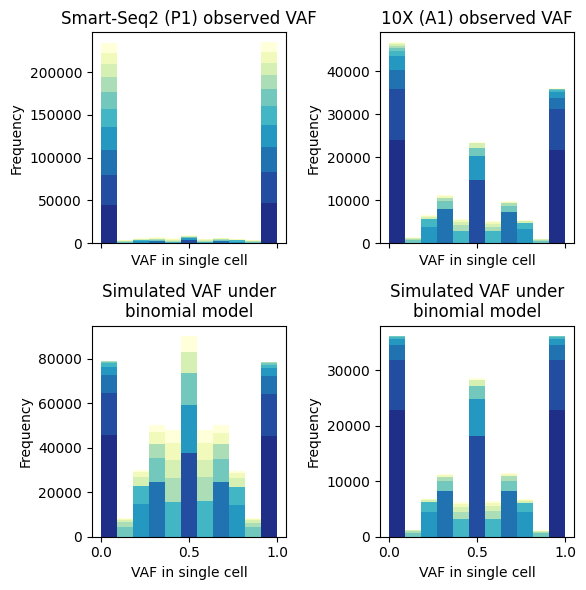

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharex=True)

ax = axs[0,0]
m_ax = axs[1,0]

adata = anndata.read_h5ad("/home/vmarotl/fast/mutaseq/runs/k2_P1_False_5.h5ad")
adata = adata[:,adata.var["dbSNP"]==True]
# real data
data, cov = (adata.layers["ALT"]/adata.X).flatten(), (adata.X).flatten()
x = [data[((cov>=i) & (cov<i+1)) if i<=(vmax_cov-1) else cov >= i] for i in range(vmax_cov)]
ax.hist(x, **hist_kwargs)
ax.set_title("Smart-Seq2 (P1) observed VAF")
ax.set_xlabel("VAF in single cell")
ax.set_ylabel("Frequency")
# simulate
sim_alt = np.random.binomial(cov, p=.5)#, size=None)
data = sim_alt/cov
x = [data[((cov>=i) & (cov<i+1)) if i<=(vmax_cov-1) else cov >= i] for i in range(vmax_cov)]
m_ax.hist(x,  **hist_kwargs)
m_ax.set_title("Simulated VAF under\nbinomial model")
m_ax.set_xlabel("VAF in single cell")
m_ax.set_ylabel("Frequency")



ax = axs[0,1]
m_ax = axs[1,1]

adata = anndata.read_h5ad("/home/vmarotl/fast/mutaseq/runs/k2_A1_False_5.h5ad")
adata = adata[:,adata.var["dbSNP"]==True]
# real data
data, cov = (adata.layers["ALT"]/adata.X).flatten(), (adata.X).flatten()
x = [data[((cov>=i) & (cov<i+1)) if i<=(vmax_cov-1) else cov >= i] for i in range(vmax_cov)]
ax.hist(x, **hist_kwargs)
ax.set_title("10X (A1) observed VAF")
ax.set_xlabel("VAF in single cell")
ax.set_ylabel("Frequency")
# simulate
sim_alt = np.random.binomial(cov, p=.5)#, size=None)
data = sim_alt/cov
x = [data[((cov>=i) & (cov<i+1)) if i<=(vmax_cov-1) else cov >= i] for i in range(vmax_cov)]
m_ax.hist(x,  **hist_kwargs)
m_ax.set_title("Simulated VAF under\nbinomial model")
m_ax.set_xlabel("VAF in single cell")
m_ax.set_ylabel("Frequency")

plt.tight_layout()

plt.savefig("../figures/S3_SmartSeq2-vs-10X-VAF-in-sc.png", dpi=300)